In [ ]:
pip install ortools


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt


In [2]:
# Load the data
path = r"C:\Users\madha\Desktop\sem 7\OR\archive\19MDVRP Problem Sets.xlsx"
data = pd.read_excel(path, sheet_name='Problem 9')  # Adjust the sheet name if needed

In [3]:

customers = data[['Customer Number', 'x coordinate', 'y coordinate']].dropna().reset_index(drop=True)
depots = data[['Number of Depots', 'Depot x coordinate', 'Depot y coordinate']].dropna().reset_index(drop=True)


In [4]:
# Rename columns for easier access
customers.columns = ['Customer', 'x', 'y']
depots.columns = ['Depot', 'x', 'y']

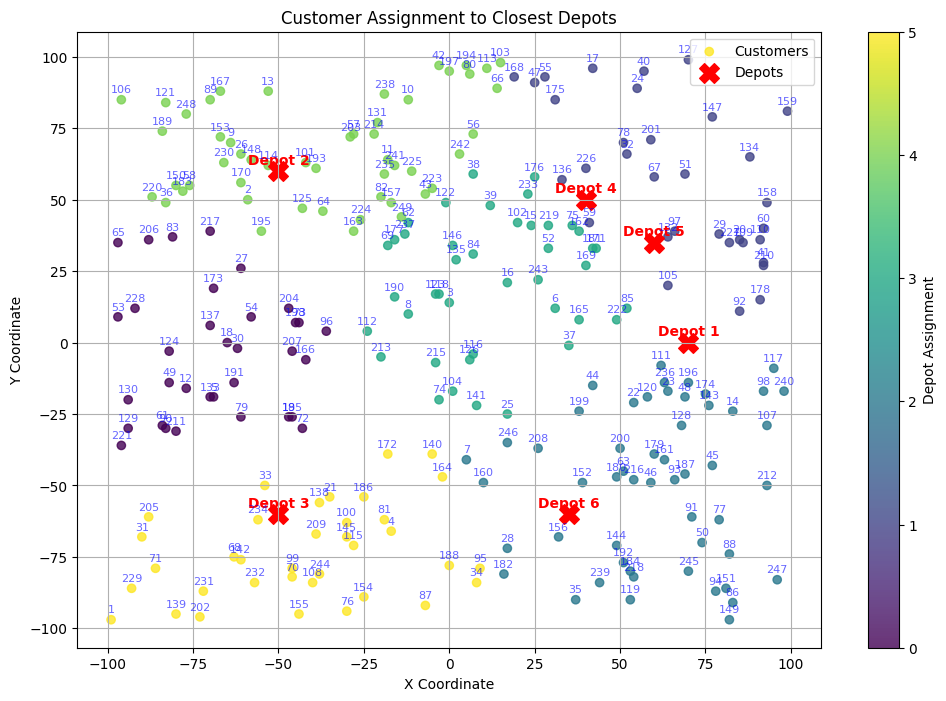

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Assign each customer to the nearest depot using K-means clustering
num_depots = len(depots)
kmeans = KMeans(n_clusters=num_depots, random_state=0).fit(customers[['x', 'y']])
customers['Depot Assignment'] = kmeans.labels_

# Visualize customer-depot assignments
plt.figure(figsize=(12, 8))

# Scatter plot for customers with depot assignments
scatter = plt.scatter(customers['x'], customers['y'], c=customers['Depot Assignment'], cmap='viridis', label='Customers', alpha=0.8)

# Plot depots as red 'X' markers
plt.scatter(depots['x'], depots['y'], c='red', marker='X', s=200, label='Depots')

# Add depot labels
for idx, row in depots.iterrows():
    plt.annotate(f"Depot {idx+1}", (row['x'], row['y']), textcoords="offset points", xytext=(0, 5), ha='center', color='red', fontsize=10, weight='bold')

# Add customer labels
for idx, row in customers.iterrows():
    plt.annotate(f"{int(row['Customer'])}", (row['x'], row['y']), textcoords="offset points", xytext=(0, 5), ha='center', color='blue', fontsize=8, alpha=0.6)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Customer Assignment to Closest Depots')
plt.colorbar(scatter, label='Depot Assignment')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np

def solve_vrp(customers_data, depot_location, depot_number):
    # Combine depot and customer coordinates into a single array for distance calculation
    locations = np.vstack([[depot_location['x'], depot_location['y']], customers_data[['x', 'y']].values])
    num_locations = len(locations)

    # Calculate the distance matrix between all locations
    def distance(x, y):
        return int(np.linalg.norm(locations[x] - locations[y]))
    
    distance_matrix = [[distance(i, j) for j in range(num_locations)] for i in range(num_locations)]

    # OR-Tools setup
    manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)  # 1 vehicle, starting at the depot
    routing = pywrapcp.RoutingModel(manager)
    
    # Register a transit callback that calculates distances based on the distance matrix
    transit_callback_index = routing.RegisterTransitCallback(
        lambda i, j: distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
    )
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set the distance dimension to track and minimize total distance
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        100000,  # large enough maximum distance
        True,  # start cumul to zero
        "Distance"
    )
    distance_dimension = routing.GetDimensionOrDie("Distance")
    distance_dimension.SetGlobalSpanCostCoefficient(1)

    # Solve the VRP with default parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    solution = routing.SolveWithParameters(search_parameters)

    # Retrieve and print the solution
    if solution:
        print(f"Route for Depot {depot_number} located at ({depot_location['x']}, {depot_location['y']}):")
        index = routing.Start(0)
        route_distance = 0
        route = []
        
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            
            # Validate indices before accessing the distance matrix
            if 0 <= previous_index < num_locations and 0 <= index < num_locations:
                route_distance += distance_matrix[previous_index][index]
            else:
                print(f" ")
        
        route.append(manager.IndexToNode(index))  # Add depot end point

        # Print route details
        print(" -> ".join(
            str(customers_data.iloc[node - 1]['Customer'] if node > 0 else "Depot") 
            for node in route
        ))
        print(f"Distance of the route: {route_distance} units\n")
    else:
        print("No solution found.")


In [11]:
for i in range(num_depots):
    depot_location = depots.iloc[i]
    assigned_customers = customers[customers['Depot Assignment'] == i].reset_index(drop=True)
    solve_vrp(assigned_customers, depot_location, depot_number=i + 1)


Route for Depot 1 located at (70.0, 0.0):
 
Depot -> 166 -> 207 -> 19 -> 185 -> 72 -> 79 -> 211 -> 90 -> 61 -> 221 -> 129 -> 130 -> 49 -> 12 -> 133 -> 5 -> 191 -> 124 -> 53 -> 228 -> 65 -> 206 -> 83 -> 217 -> 27 -> 173 -> 137 -> 18 -> 30 -> 54 -> 204 -> 198 -> 73 -> 96 -> Depot
Distance of the route: 428 units

Route for Depot 2 located at (-50.0, 60.0):
 
Depot -> 168 -> 47 -> 55 -> 175 -> 17 -> 24 -> 40 -> 127 -> 147 -> 159 -> 134 -> 158 -> 60 -> 110 -> 41 -> 210 -> 178 -> 92 -> 105 -> 132 -> 97 -> 29 -> 227 -> 20 -> 109 -> 51 -> 67 -> 201 -> 78 -> 32 -> 226 -> 136 -> 59 -> Depot
Distance of the route: 423 units

Route for Depot 3 located at (-50.0, -60.0):
 
Depot -> 7 -> 160 -> 246 -> 208 -> 199 -> 44 -> 22 -> 120 -> 23 -> 236 -> 111 -> 196 -> 48 -> 174 -> 98 -> 117 -> 240 -> 107 -> 14 -> 143 -> 128 -> 161 -> 179 -> 200 -> 152 -> 180 -> 63 -> 216 -> 46 -> 93 -> 187 -> 45 -> 212 -> 77 -> 91 -> 50 -> 88 -> 247 -> 149 -> 86 -> 151 -> 94 -> 245 -> 119 -> 218 -> 184 -> 192 -> 144 -> 239

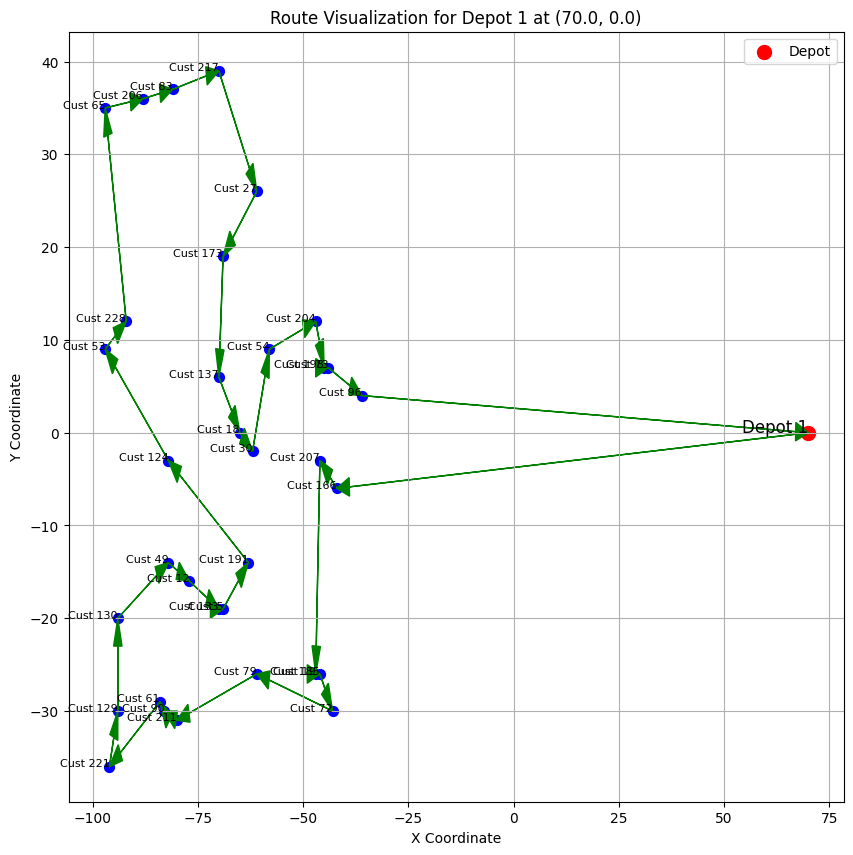

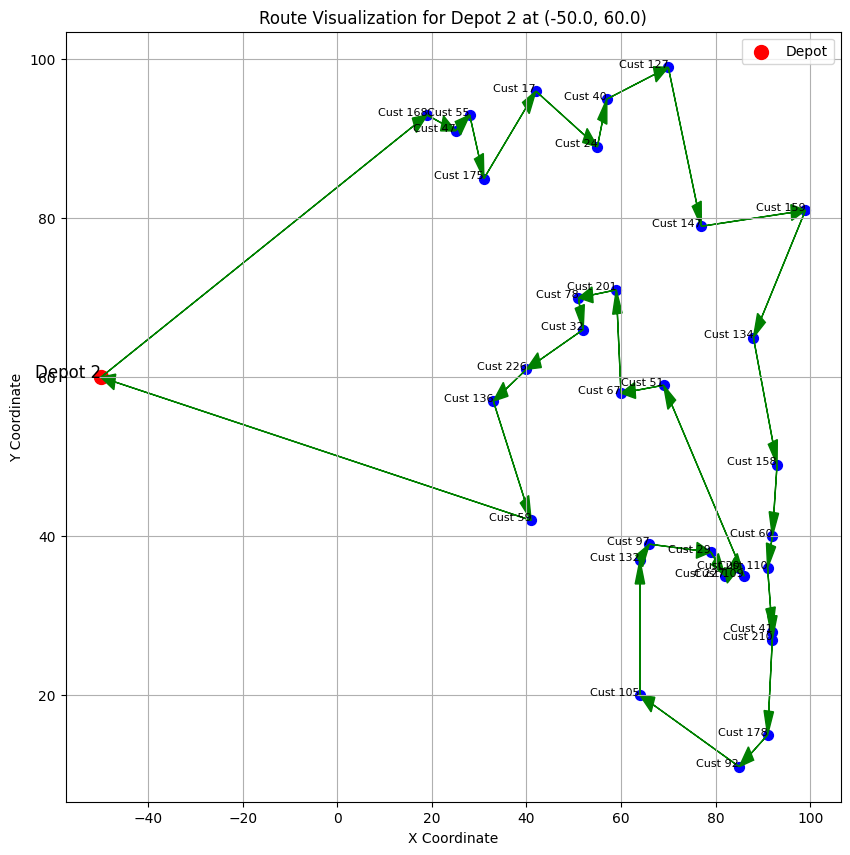

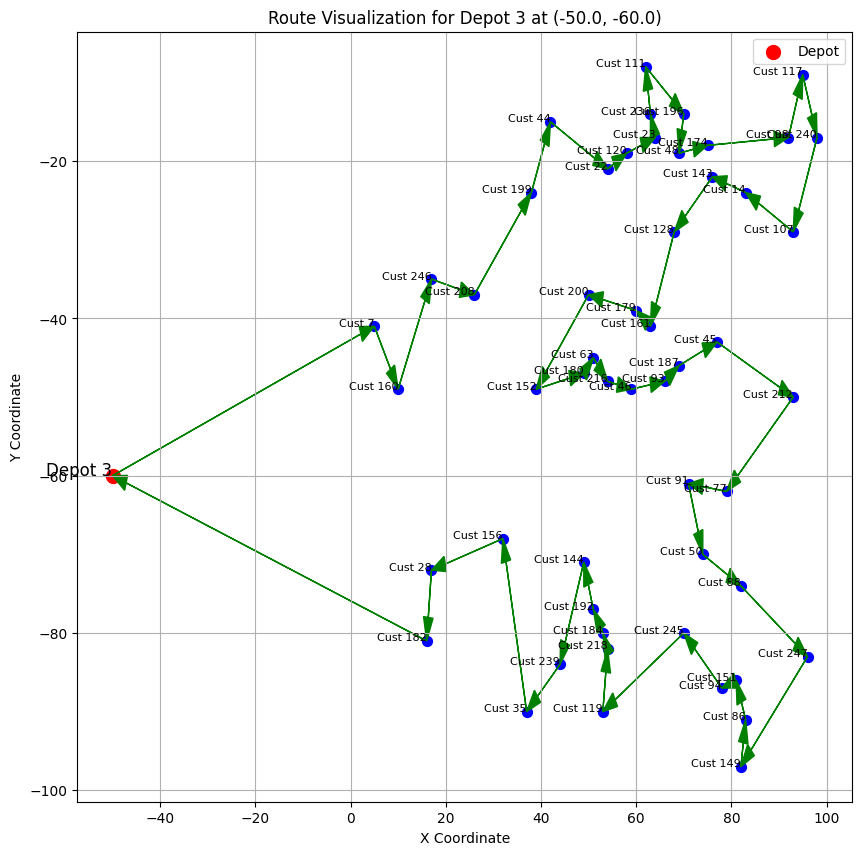

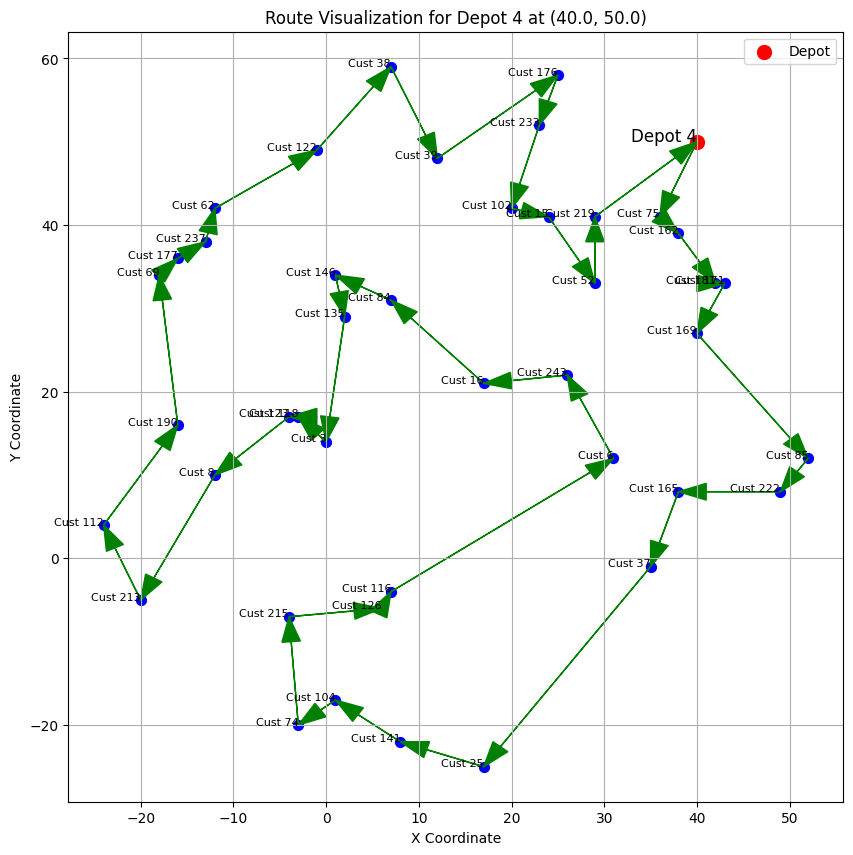

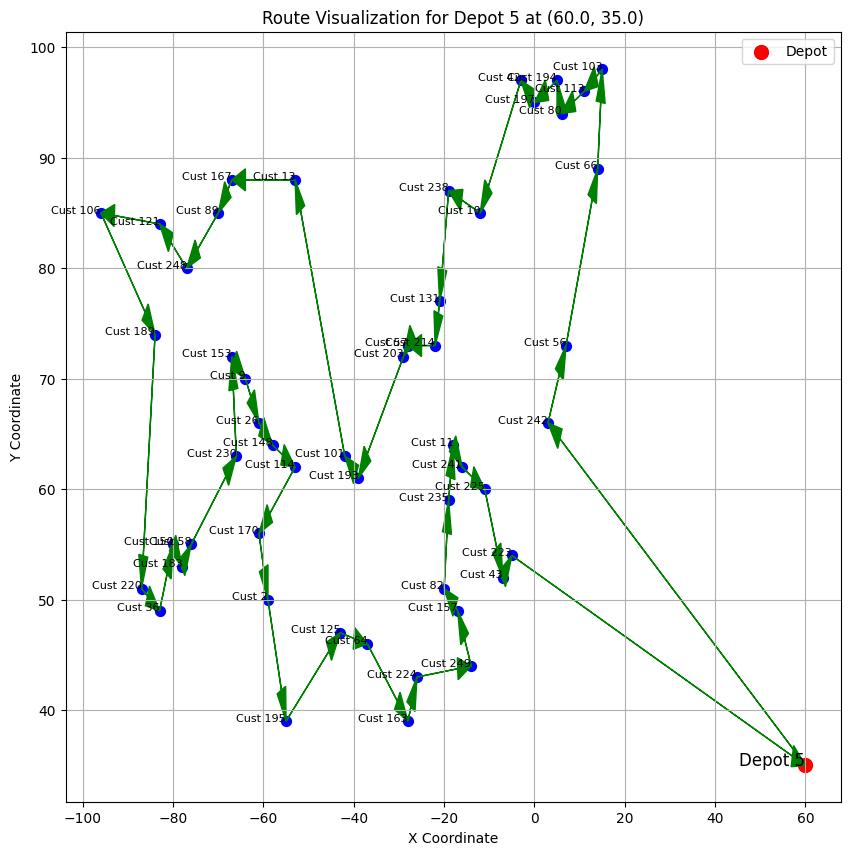

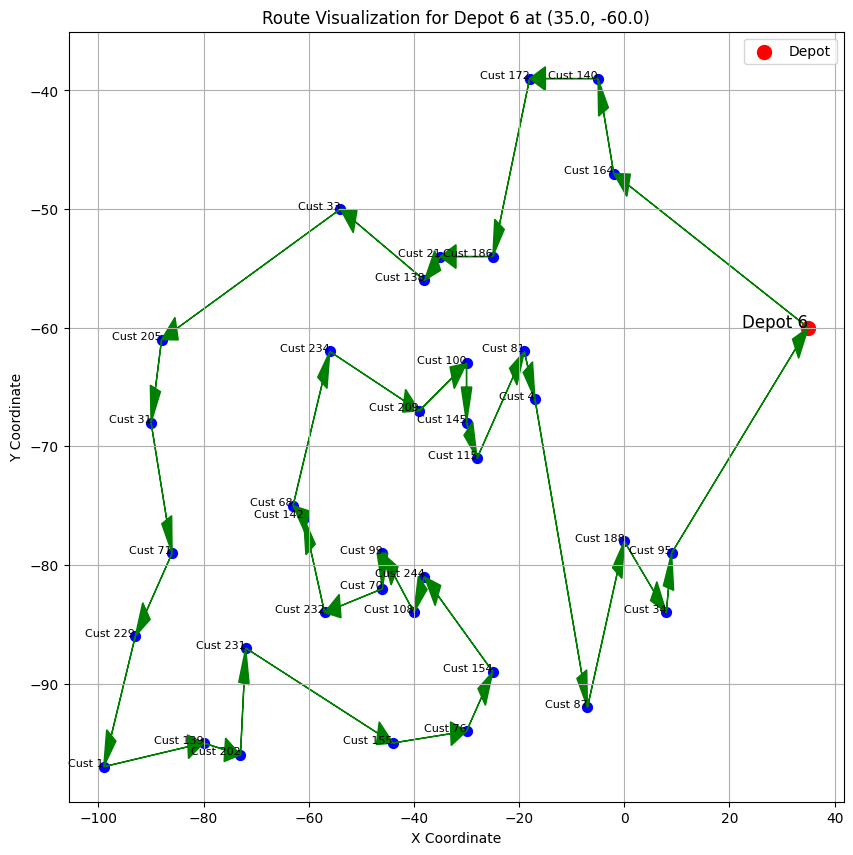

In [13]:
import matplotlib.pyplot as plt

# Step 4: Visualization function
def visualize_route(route, locations, depot_location, customers_data, depot_number):
    plt.figure(figsize=(10, 10))
    
    # Plot depot
    plt.scatter(depot_location['x'], depot_location['y'], color='red', s=100, label='Depot')
    plt.text(depot_location['x'], depot_location['y'], f"Depot {depot_number}", fontsize=12, ha='right')
    
    # Plot customers
    for i, row in customers_data.iterrows():
        plt.scatter(row['x'], row['y'], color='blue', s=50)
        plt.text(row['x'], row['y'], f"Cust {row['Customer']}", fontsize=8, ha='right')
    
    # Plot route
    for i in range(1, len(route)):
        start_idx = route[i - 1]
        end_idx = route[i]
        start_location = locations[start_idx]
        end_location = locations[end_idx]
        
        plt.arrow(start_location[0], start_location[1], 
                  end_location[0] - start_location[0], end_location[1] - start_location[1],
                  color='green', head_width=2, length_includes_head=True)
    
    plt.title(f"Route Visualization for Depot {depot_number} at ({depot_location['x']}, {depot_location['y']})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid()
    plt.show()

def run_visualization_for_all_routes(num_depots, depots, customers):
    for i in range(num_depots):
        depot_location = depots.iloc[i]
        assigned_customers = customers[customers['Depot Assignment'] == i].reset_index(drop=True)
        
        # Calculate the distance matrix and get the route from Step 3
        locations = np.vstack([[depot_location['x'], depot_location['y']], assigned_customers[['x', 'y']].values])
        num_locations = len(locations)
        
        def distance(x, y):
            return int(np.linalg.norm(locations[x] - locations[y]))
        
        distance_matrix = [[distance(i, j) for j in range(num_locations)] for i in range(num_locations)]
        
        # OR-Tools setup for retrieving the route without solving again
        manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        transit_callback_index = routing.RegisterTransitCallback(
            lambda i, j: distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
        )
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        routing.AddDimension(transit_callback_index, 0, 100000, True, "Distance")
        
        # Solve to retrieve the solution
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))  # Add depot end point

            # Visualize the route, passing the depot number
            visualize_route(route, locations, depot_location, assigned_customers, depot_number=i+1)
        else:
            print(f"No solution found for Depot {i + 1}.")

# Execute Step 4 to visualize all routes
run_visualization_for_all_routes(num_depots, depots, customers)


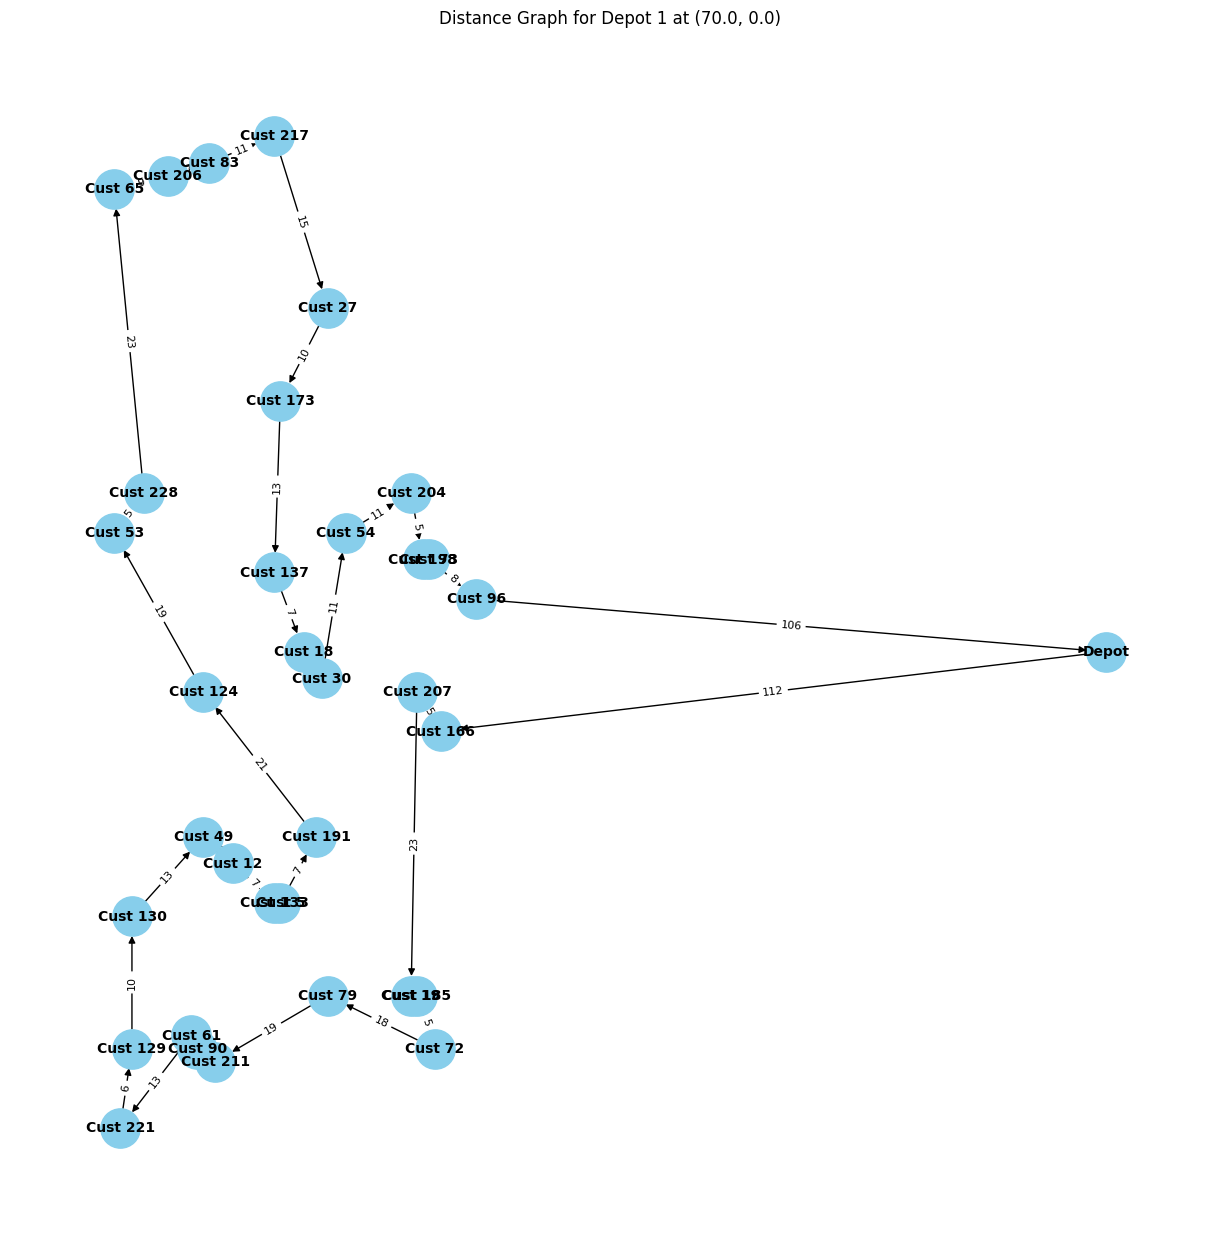

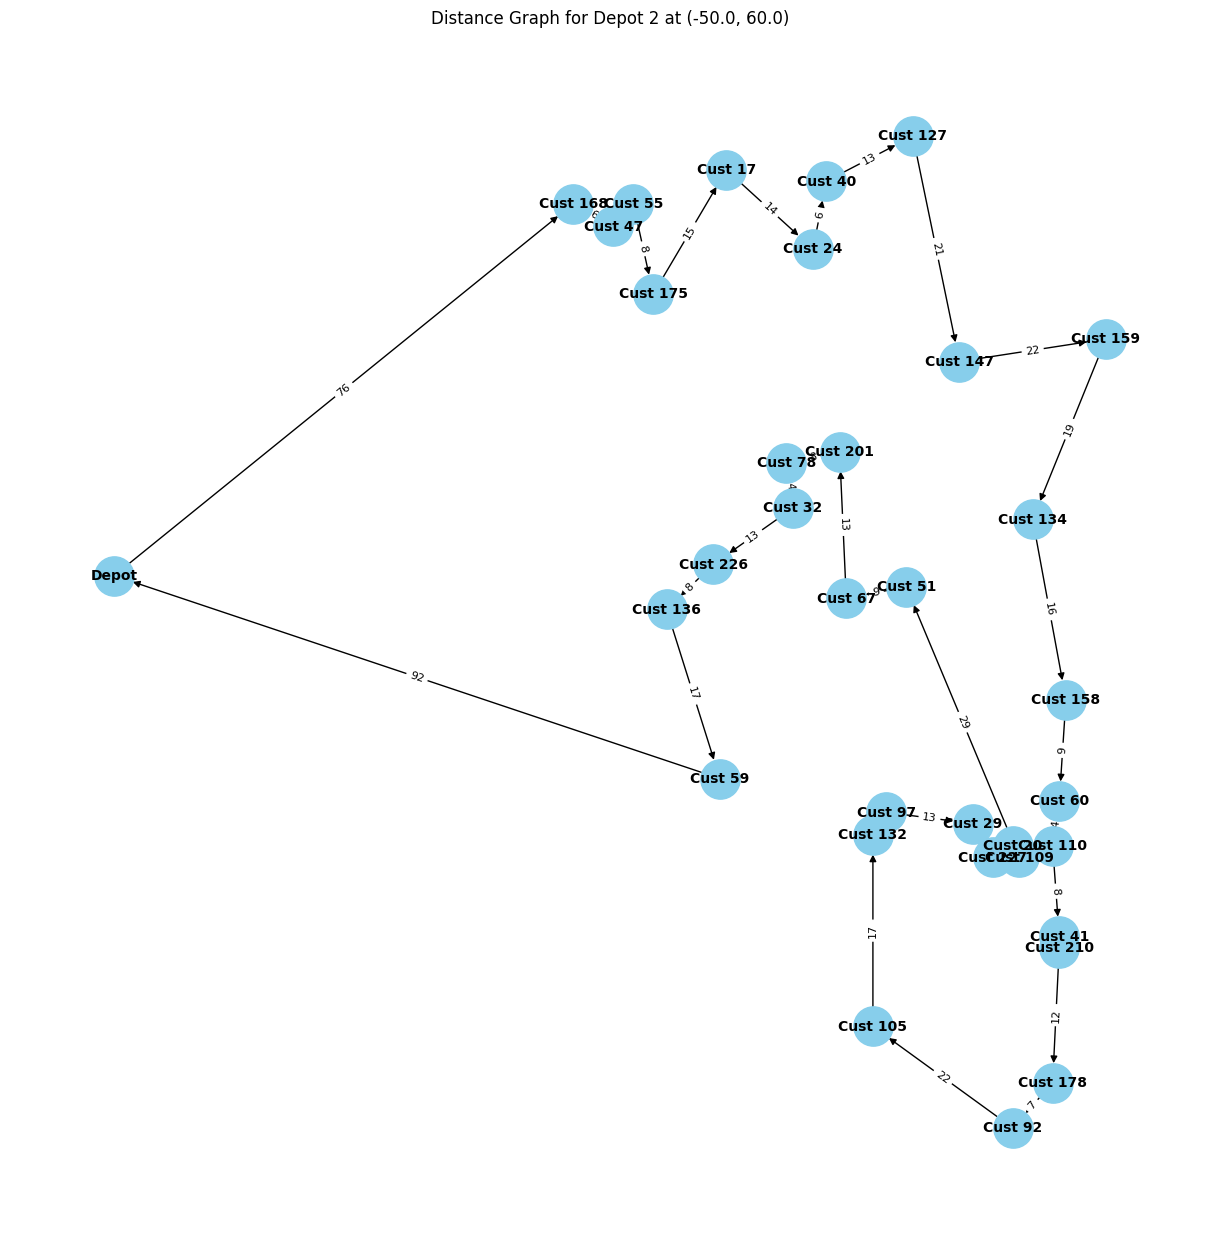

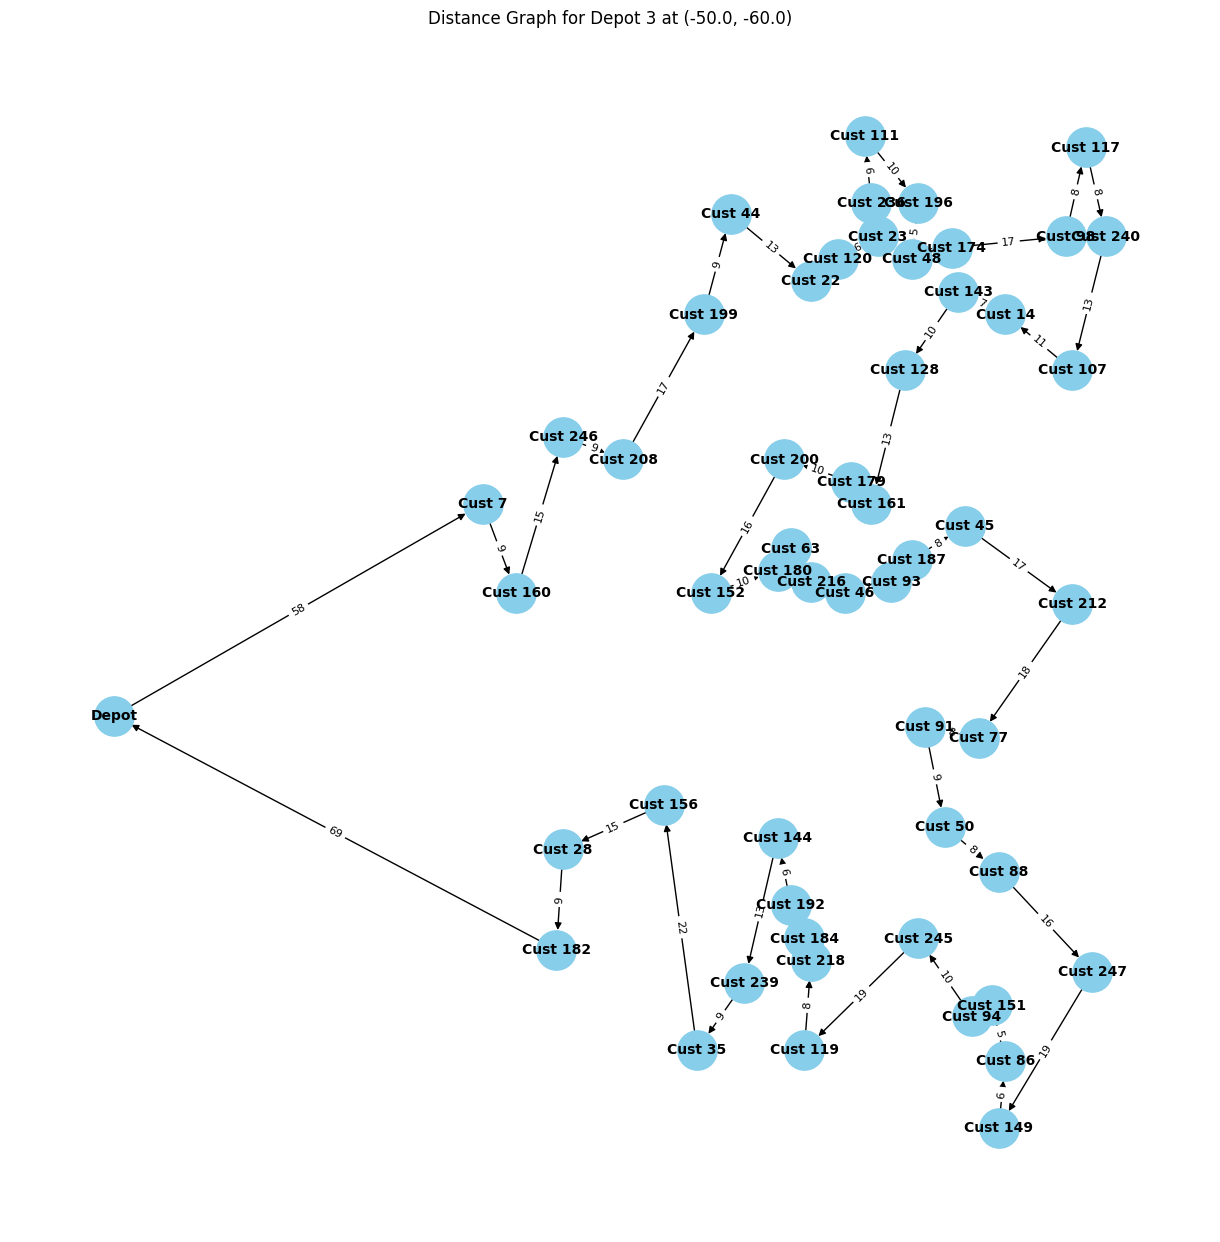

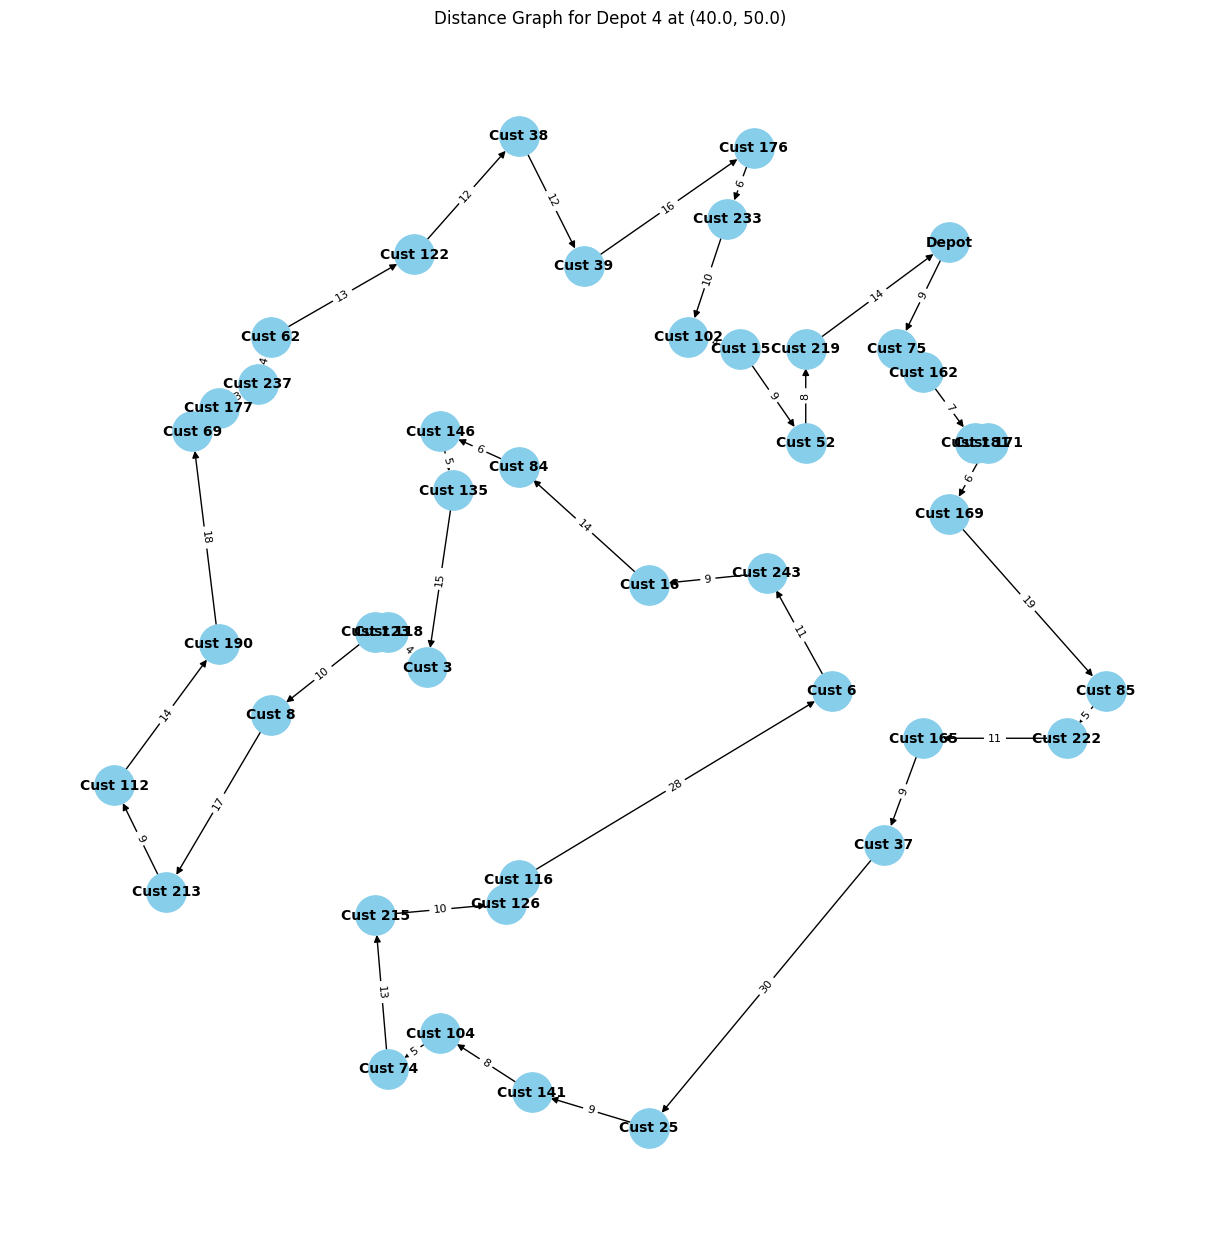

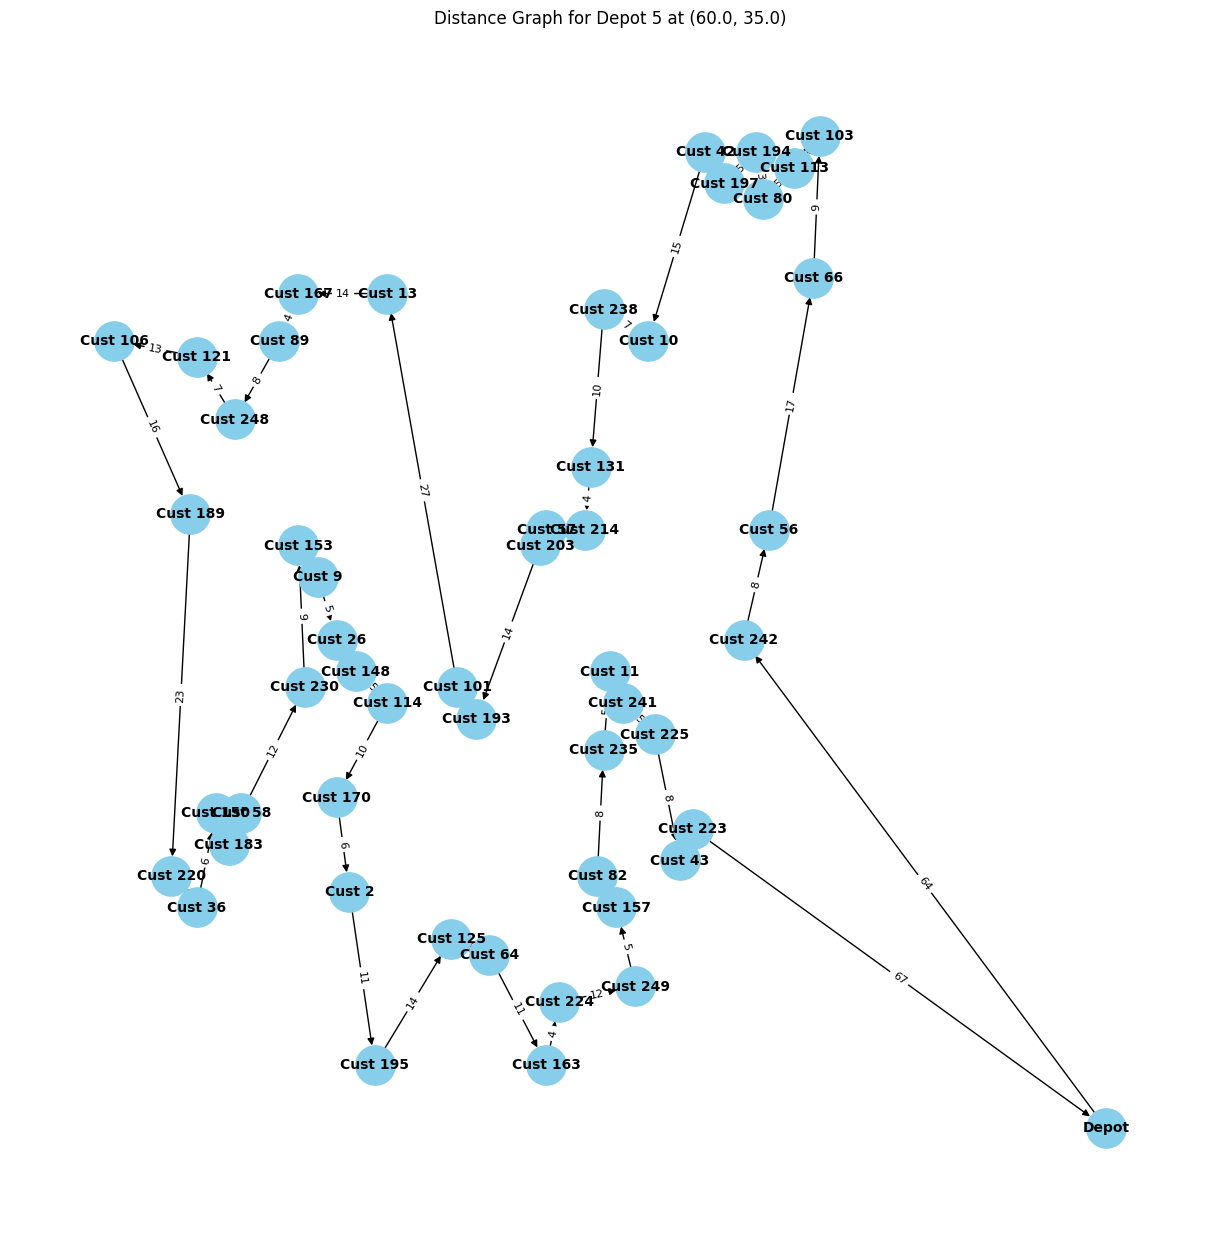

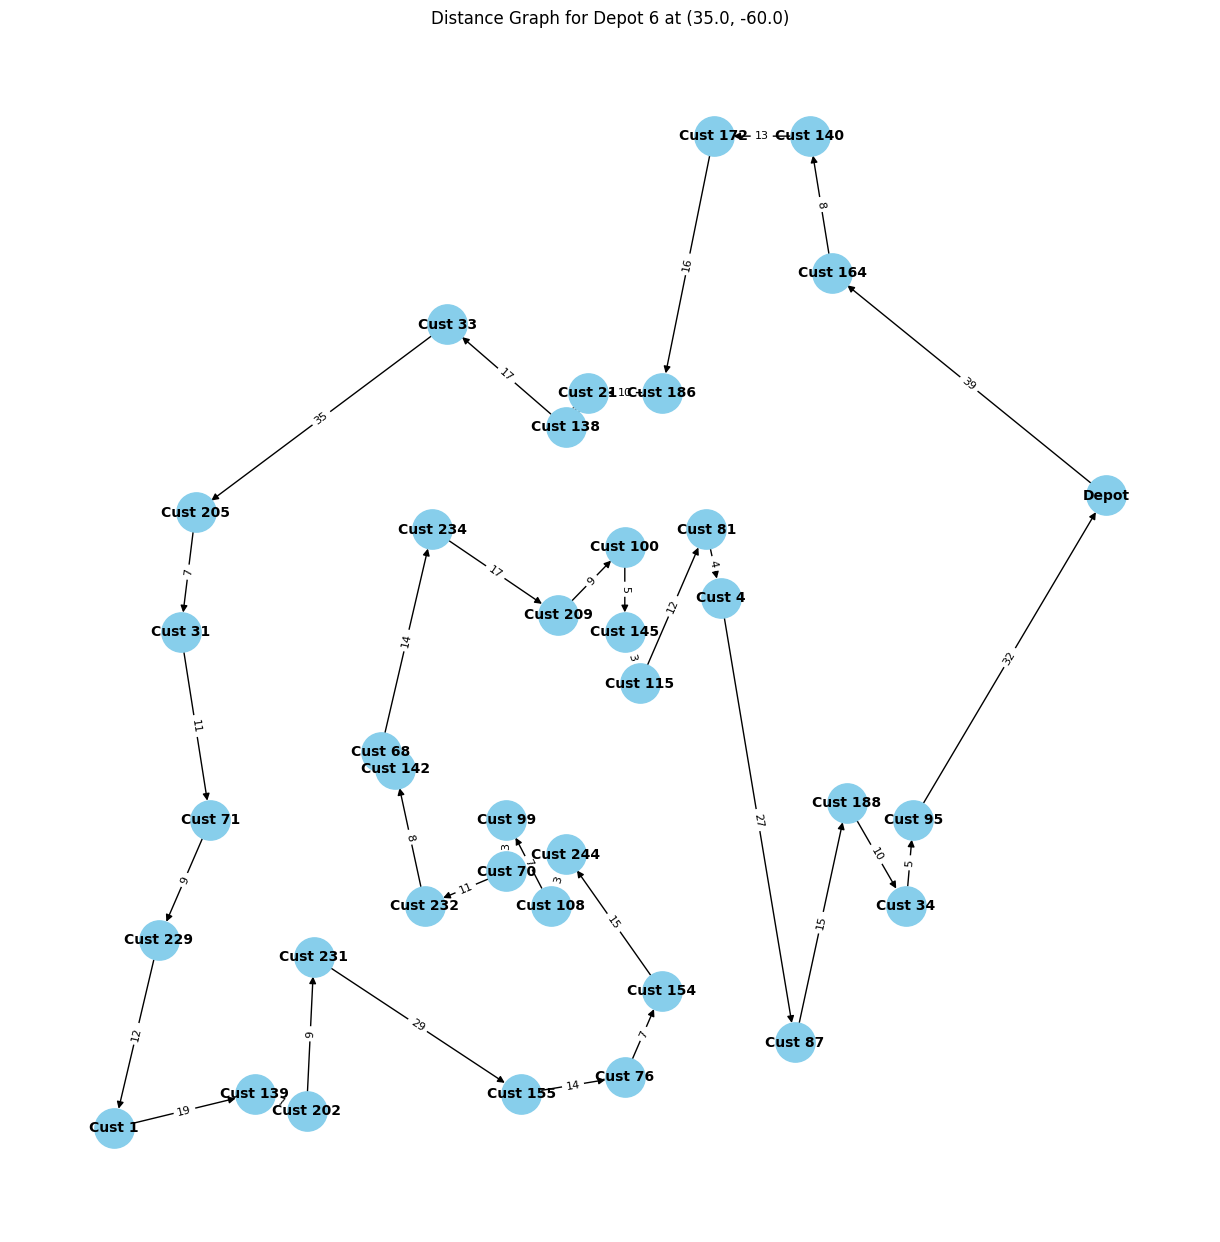

In [15]:
import networkx as nx

# Step 5: Plot distance graph with distances between customers in the optimal path
def plot_distance_graph(route, distance_matrix, depot_location, assigned_customers,depot_number):
    # Initialize graph
    G = nx.DiGraph()
    
    # Add nodes (Depot and customers)
    G.add_node("Depot", pos=(depot_location['x'], depot_location['y']))
    for idx, customer in assigned_customers.iterrows():
        G.add_node(f"Cust {customer['Customer']}", pos=(customer['x'], customer['y']))
    
    # Add edges with distances
    for i in range(1, len(route)):
        start_idx = route[i - 1]
        end_idx = route[i]
        
        # Determine the node labels for the plot
        start_node = "Depot" if start_idx == 0 else f"Cust {assigned_customers.iloc[start_idx - 1]['Customer']}"
        end_node = "Depot" if end_idx == 0 else f"Cust {assigned_customers.iloc[end_idx - 1]['Customer']}"
        
        # Get distance from the matrix
        distance = distance_matrix[start_idx][end_idx]
        
        # Add edge with distance as weight
        G.add_edge(start_node, end_node, weight=distance)

    # Plotting the graph with edge labels
    pos = nx.get_node_attributes(G, 'pos')
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Distance Graph for Depot {depot_number} at ({depot_location['x']}, {depot_location['y']})")
    plt.show()

# Run distance graph plotting for each depot's route
def plot_distance_graphs_for_all_depots(num_depots, depots, customers):
    for i in range(num_depots):
        depot_location = depots.iloc[i]
        assigned_customers = customers[customers['Depot Assignment'] == i].reset_index(drop=True)
        
        # Calculate the distance matrix and get the route from Step 3
        locations = np.vstack([[depot_location['x'], depot_location['y']], assigned_customers[['x', 'y']].values])
        num_locations = len(locations)
        
        def distance(x, y):
            return int(np.linalg.norm(locations[x] - locations[y]))
        
        distance_matrix = [[distance(i, j) for j in range(num_locations)] for i in range(num_locations)]
        
        # OR-Tools setup for retrieving the route without solving again
        manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        transit_callback_index = routing.RegisterTransitCallback(
            lambda i, j: distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
        )
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        routing.AddDimension(transit_callback_index, 0, 100000, True, "Distance")
        
        # Solve to retrieve the solution
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))  # Add depot end point

            # Plot the distance graph for the route
            plot_distance_graph(route, distance_matrix, depot_location, assigned_customers,depot_number=i+1)
        else:
            print("No solution found.")

# Execute Step 5 to plot distance graphs for all depots
plot_distance_graphs_for_all_depots(num_depots, depots, customers)


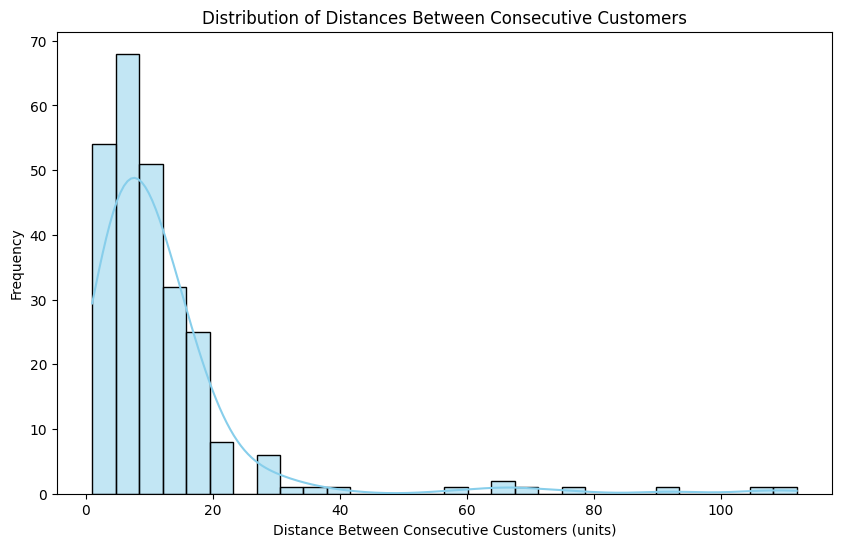

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 6: Plot distribution of distances between consecutive customers
def plot_distance_distribution(routes_per_depot, distance_matrices):
    all_distances = []

    # Iterate through each depot's routes and its respective distance matrix
    for routes, distance_matrix in zip(routes_per_depot, distance_matrices):
        for route in routes:
            for i in range(1, len(route)):
                # Extract start and end indices
                start_idx = route[i - 1]
                end_idx = route[i]
                # Add distance to the list
                all_distances.append(distance_matrix[start_idx][end_idx])

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(all_distances, bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title("Distribution of Distances Between Consecutive Customers")
    plt.xlabel("Distance Between Consecutive Customers (units)")
    plt.ylabel("Frequency")
    plt.show()

# Retrieve the optimal routes from Step 4 and distance matrices for each depot
def calculate_and_plot_distance_distribution(num_depots, depots, customers):
    routes_per_depot = []
    distance_matrices = []
    
    for i in range(num_depots):
        depot_location = depots.iloc[i]
        assigned_customers = customers[customers['Depot Assignment'] == i].reset_index(drop=True)
        
        # Calculate the distance matrix and get the route from Step 3
        locations = np.vstack([[depot_location['x'], depot_location['y']], assigned_customers[['x', 'y']].values])
        num_locations = len(locations)
        
        def distance(x, y):
            return int(np.linalg.norm(locations[x] - locations[y]))
        
        distance_matrix = [[distance(i, j) for j in range(num_locations)] for i in range(num_locations)]
        distance_matrices.append(distance_matrix)  # Store each depot's distance matrix
        
        # OR-Tools setup for retrieving the route without solving again
        manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        transit_callback_index = routing.RegisterTransitCallback(
            lambda i, j: distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
        )
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        
        # Solve to retrieve the solution
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))  # Add depot end point

            # Store the route for this depot
            routes_per_depot.append([route])

    # Plot the distance distribution
    plot_distance_distribution(routes_per_depot, distance_matrices)

# Execute Step 6 to plot the distance distribution for all depots
calculate_and_plot_distance_distribution(num_depots, depots, customers)


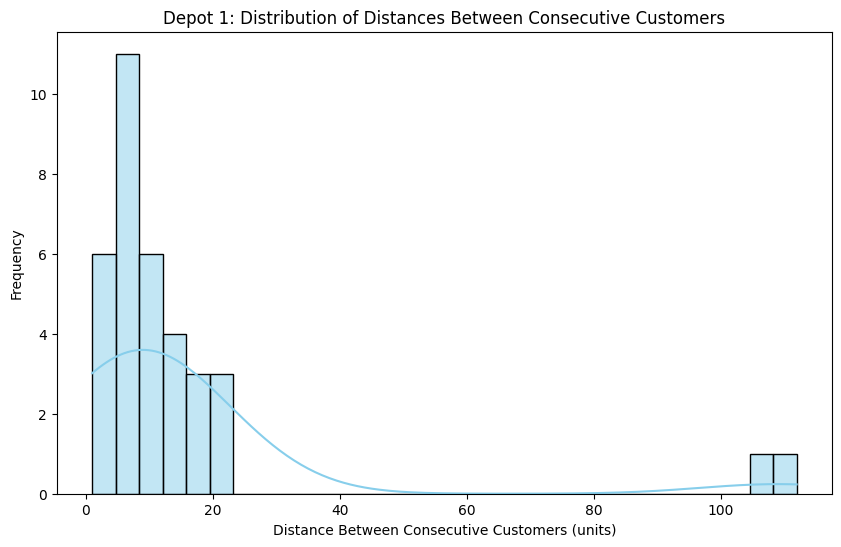

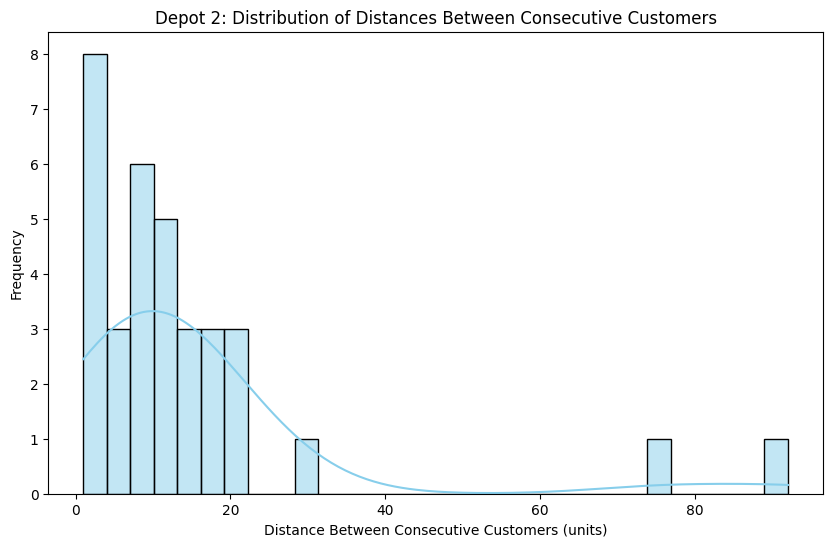

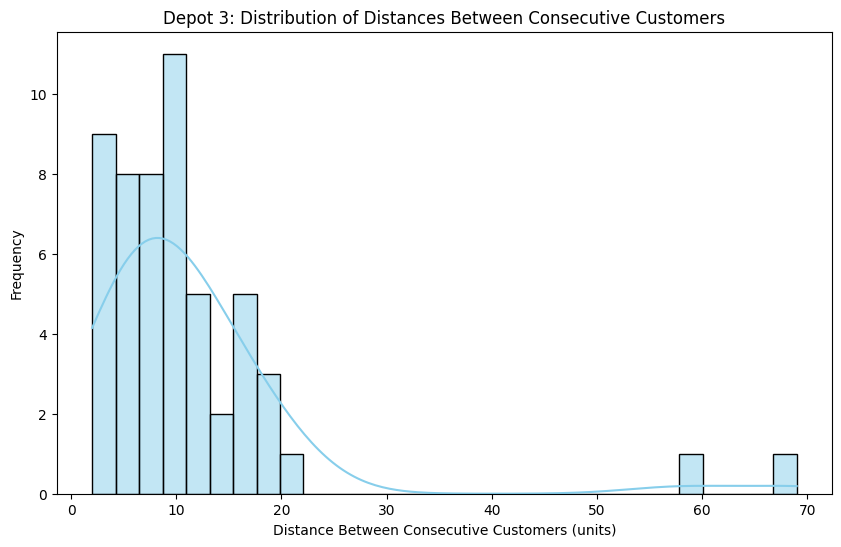

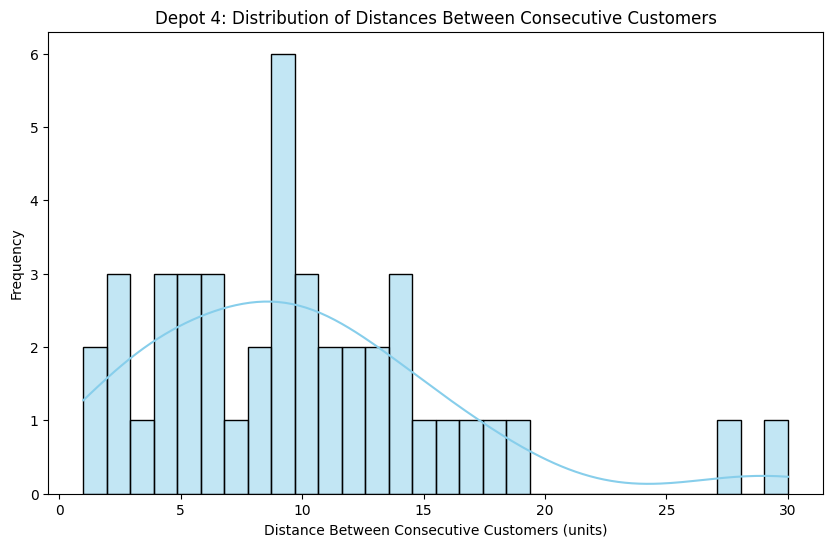

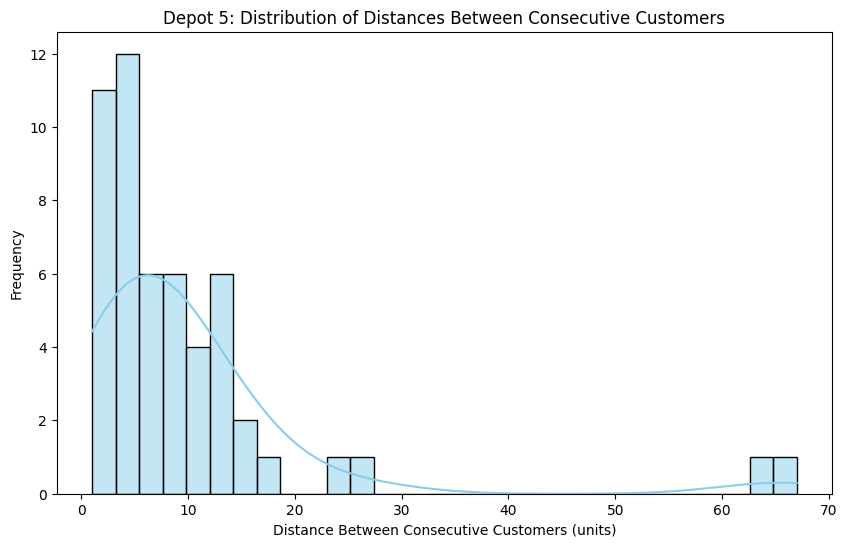

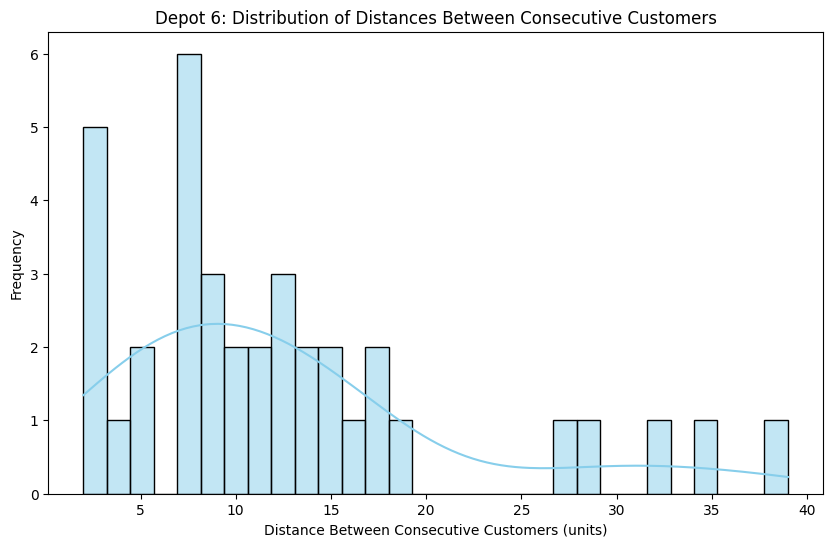

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Step 6: Plot distribution of distances for each depot
def plot_distance_distribution_per_depot(routes_per_depot, distance_matrices):
    for depot_index, (routes, distance_matrix) in enumerate(zip(routes_per_depot, distance_matrices)):
        depot_distances = []

        # Collect distances for this depot
        for route in routes:
            for i in range(1, len(route)):
                start_idx = route[i - 1]
                end_idx = route[i]
                depot_distances.append(distance_matrix[start_idx][end_idx])

        # Plotting the histogram for the depot
        plt.figure(figsize=(10, 6))
        sns.histplot(depot_distances, bins=30, kde=True, color='skyblue', edgecolor='black')
        plt.title(f"Depot {depot_index + 1}: Distribution of Distances Between Consecutive Customers")
        plt.xlabel("Distance Between Consecutive Customers (units)")
        plt.ylabel("Frequency")
        plt.show()

# Main function for calculating and plotting distributions
def calculate_and_plot_distance_distribution(num_depots, depots, customers):
    routes_per_depot = []
    distance_matrices = []

    for i in range(num_depots):
        depot_location = depots.iloc[i]
        assigned_customers = customers[customers['Depot Assignment'] == i].reset_index(drop=True)

        # Calculate the distance matrix and route
        locations = np.vstack([[depot_location['x'], depot_location['y']], assigned_customers[['x', 'y']].values])
        num_locations = len(locations)

        def distance(x, y):
            return int(np.linalg.norm(locations[x] - locations[y]))

        distance_matrix = [[distance(i, j) for j in range(num_locations)] for i in range(num_locations)]
        distance_matrices.append(distance_matrix)

        # OR-Tools setup for routing
        manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        transit_callback_index = routing.RegisterTransitCallback(
            lambda i, j: distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
        )
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Solve to retrieve the solution
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))  # Add depot end point

            # Store the route for this depot
            routes_per_depot.append([route])

    # Plot the distance distribution for each depot
    plot_distance_distribution_per_depot(routes_per_depot, distance_matrices)

# Execute the function
calculate_and_plot_distance_distribution(num_depots, depots, customers)


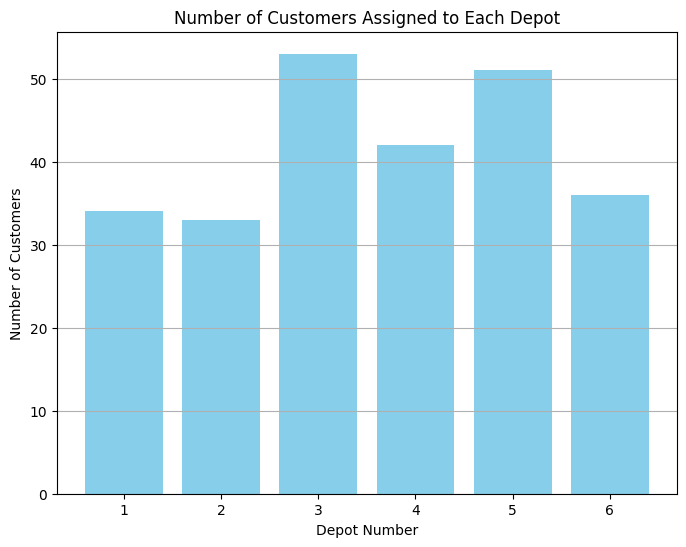

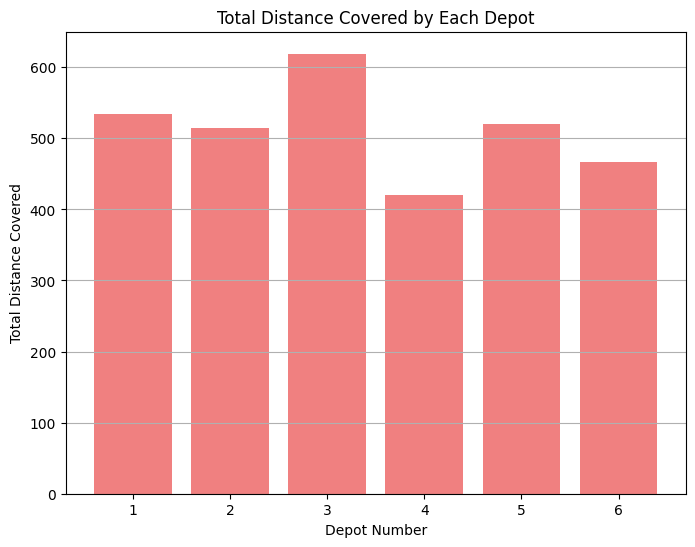

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Helper function to calculate total distance for a route
def calculate_total_distance(route, distance_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    return total_distance

# Main function to execute route calculation, visualization, and distance distribution analysis
def run_visualization_summary_and_distribution(num_depots, depots, customers):
    customer_count = []
    total_distances = []
    routes_per_depot = []
    distance_matrices = []

    for i in range(num_depots):
        depot_location = depots.iloc[i]
        assigned_customers = customers[customers['Depot Assignment'] == i].reset_index(drop=True)
        customer_count.append(len(assigned_customers))  # Store number of customers

        # Calculate the distance matrix
        locations = np.vstack([[depot_location['x'], depot_location['y']], assigned_customers[['x', 'y']].values])
        num_locations = len(locations)

        def distance(x, y):
            return int(np.linalg.norm(locations[x] - locations[y]))

        distance_matrix = [[distance(i, j) for j in range(num_locations)] for i in range(num_locations)]
        distance_matrices.append(distance_matrix)

        # OR-Tools setup for retrieving the route without solving again
        manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        transit_callback_index = routing.RegisterTransitCallback(
            lambda i, j: distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
        )
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Solve to retrieve the solution
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))  # Add depot end point

            # Calculate total distance for this depot's route
            total_distance = calculate_total_distance(route, distance_matrix)
            total_distances.append(total_distance)
            routes_per_depot.append([route])  # Store the route for this depot
        else:
            print(f"No solution found for Depot {i + 1}.")
            total_distances.append(0)
            routes_per_depot.append([])

    # Plot 1: Number of customers assigned to each depot
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, num_depots + 1), customer_count, color='skyblue')
    plt.xlabel('Depot Number')
    plt.ylabel('Number of Customers')
    plt.title('Number of Customers Assigned to Each Depot')
    plt.grid(axis='y')
    plt.show()

    # Plot 2: Total distance covered by each depot
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, num_depots + 1), total_distances, color='lightcoral')
    plt.xlabel('Depot Number')
    plt.ylabel('Total Distance Covered')
    plt.title('Total Distance Covered by Each Depot')
    plt.grid(axis='y')
    plt.show()



# Execute the function
run_visualization_summary_and_distribution(num_depots, depots, customers)


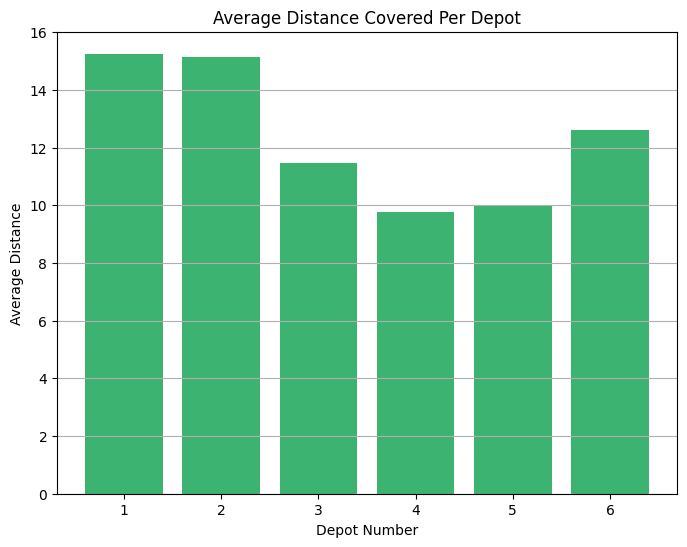

In [24]:
# Function to calculate and plot the average distance for each depot
def plot_average_distance_per_depot(num_depots, depots, customers):
    average_distances = []

    for i in range(num_depots):
        depot_location = depots.iloc[i]
        assigned_customers = customers[customers['Depot Assignment'] == i].reset_index(drop=True)

        # Calculate the distance matrix
        locations = np.vstack([[depot_location['x'], depot_location['y']], assigned_customers[['x', 'y']].values])
        num_locations = len(locations)

        def distance(x, y):
            return int(np.linalg.norm(locations[x] - locations[y]))

        distance_matrix = [[distance(i, j) for j in range(num_locations)] for i in range(num_locations)]

        # OR-Tools setup for retrieving the route without solving again
        manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        transit_callback_index = routing.RegisterTransitCallback(
            lambda i, j: distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
        )
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Solve to retrieve the solution
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))  # Add depot end point

            # Calculate the total and average distance for the depot
            total_distance = 0
            for j in range(len(route) - 1):
                total_distance += distance_matrix[route[j]][route[j + 1]]
            average_distance = total_distance / max(1, len(route) - 1)  # Avoid division by zero
            average_distances.append(average_distance)
        else:
            print(f"No solution found for Depot {i + 1}.")
            average_distances.append(0)

    # Plot the average distances
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, num_depots + 1), average_distances, color='mediumseagreen')
    plt.xlabel('Depot Number')
    plt.ylabel('Average Distance')
    plt.title('Average Distance Covered Per Depot')
    plt.grid(axis='y')
    plt.show()

# Execute the function
plot_average_distance_per_depot(num_depots, depots, customers)
